# Uma breve descrição sobre CRM

CRM (Customer Relationship Management, ou Gestão de Relacionamento com o Cliente) é um conjunto de estratégias, práticas e tecnologias utilizadas pelas empresas para gerenciar e analisar as interações com os clientes. O objetivo principal é melhorar o relacionamento com o cliente, aumentar a fidelidade e, por consequência, impulsionar as vendas e a retenção de clientes. O CRM permite que as empresas centralizem informações importantes sobre seus clientes e utilizem esses dados para oferecer um atendimento personalizado e eficiente.

# Bibliotecas

In [ ]:
# Instalação
!pip install lifetimes
!pip install squarify

In [ ]:
# Importação
import os
import datetime
import squarify
import warnings
import pandas as pd
import numpy as np
import datetime as dt
from operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

# Configurações do Matplotlib
%matplotlib inline

# Configuração de visualização
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
palette = 'Set2'


# Variaveis do dataset

*   InvoiceNo: Número do pedido
*   StockCode: Código do produto
*   Description: Nome do produto
*   Quantity: Quantidade de produto
*   InvoiceDate: Dia e horário da transação
*   UnitPrice: Valor da unidade
*   CustomerID: Número único de cada cliente
*   Country: País do cliente

# Importação e visualização  do Dataset

In [44]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [30]:

def check_data(dataframe, head=5):
    print(" SHAPE ".center(70, '-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))

    print(" TYPES ".center(70, '-'))
    print(dataframe.dtypes)

    print(" HEAD ".center(70, '-'))
    print(dataframe.head(head))

    print(" TAIL ".center(70, '-'))
    print(dataframe.tail(head))

    print(" MISSING VALUES ".center(70, '-'))
    print(dataframe.isnull().sum())

    print(" DUPLICATED VALUES ".center(70, '-'))
    print(dataframe.duplicated().sum())

    print(" QUANTILES (Numerical Columns Only) ".center(70, '-'))
    numerical_cols = dataframe.select_dtypes(include=['number'])
    print(numerical_cols.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

# Executar a função com o novo dataset
check_data(df)

------------------------------- SHAPE --------------------------------
Rows: 541909
Columns: 8
------------------------------- TYPES --------------------------------
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object
-------------------------------- HEAD --------------------------------
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8

▶ Essa função nos permite analisar algumas informações pertinentes a respeito do dataset. Aqui vemos as colunas, os tipos de dados, dados faltantes e até dados duplicados. Essa visualização é importante para saber o tipo de tratamento que daremos para os dados.

In [46]:
world_map = df[['CustomerID', 'InvoiceNo', 'Country']
              ].groupby(['CustomerID', 'InvoiceNo', 'Country']
                       ).count().reset_index(drop = False)
countries = world_map['Country'].value_counts()
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Pedidos'},
            colorscale='Viridis',
            reversescale = False)

layout = dict(title={'text': "Número de pedidos por país",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

▶ Usar um mapa como elemento gráfico em uma análise é a maneira mais ilustrativa para vermos a quantidade de pedidos por país. Aqui podemos ver que que o líder disparado de compras é o Reino Unido, seguido de longe pela Alemanha e França. Apesar de ser um comércio online, a maior parte das vendas continuam ao redor do país de origem.

# Métricas estatísticas

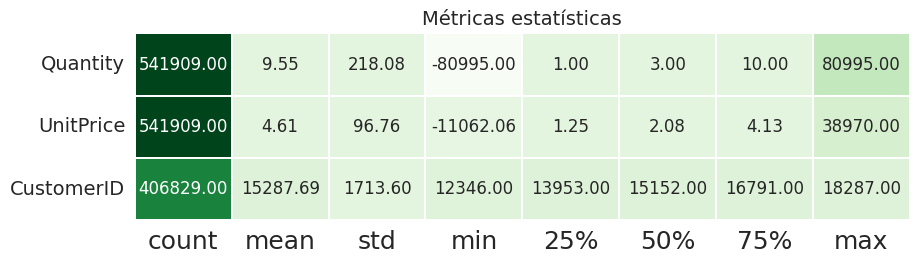

In [47]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index= dataframe.columns,
                           columns= dataframe.describe().T.columns,
                           data= dataframe.describe().T)

    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0] * 0.81))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Greens",
                fmt = '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.1,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Métricas estatísticas", size = 14)
    plt.show()

desc_stats(df.select_dtypes(include = [float, int]))

▶ O quartil é usado para dividir o conjunto de dados em quatro partes iguais, ajudando a identificar variações significativas, como valores atípicos (outliers). Ele permite detectar compras fora da curva ou inconsistências nos dados ao comparar os dados em diferentes intervalos.

▶ Podemos ver que há outliers em Quantity e UnitPrice que precisam ser tratados, além de valores negativos nas colunas devido a pedidos cancelados. Também faltam dados em Customer ID e Description. Por fim, é necessário multiplicar Quantity por UnitPrice para calcular o valor total.

# Pré-processamento

In [49]:
def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):

    '''
    Detecta outliers pelo método IQR alterando os valores.

    '''

    df_ = dataframe.copy()
    quartile1 = df_[variable].quantile(q1)
    quartile3 = df_[variable].quantile(q3)
    iqr = quartile3 - quartile1

    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df_.loc[(df_[variable] < low_limit), variable] = low_limit
    df_.loc[(df_[variable] > up_limit), variable] = up_limit

    return df_

def ecommerce_preprocess(dataframe):
    df_ = dataframe.copy()

    # Valores vazios
    df_ = df_.dropna()

    # Pedidos cancelados
    df_ = df_[~df_['InvoiceNo'].str.contains('C', na = False)]
    df_ = df_[df_['Quantity'] > 0]

    # Substituindo outliers
    df_ = replace_with_thresholds(df_, "Quantity", q1 = 0.01, q3 = 0.99)
    df_ = replace_with_thresholds(df_, "UnitPrice", q1 = 0.01, q3 = 0.99)

    # Preço total
    df_["TotalPrice"] = df_["Quantity"] * df_["UnitPrice"]

    return df_

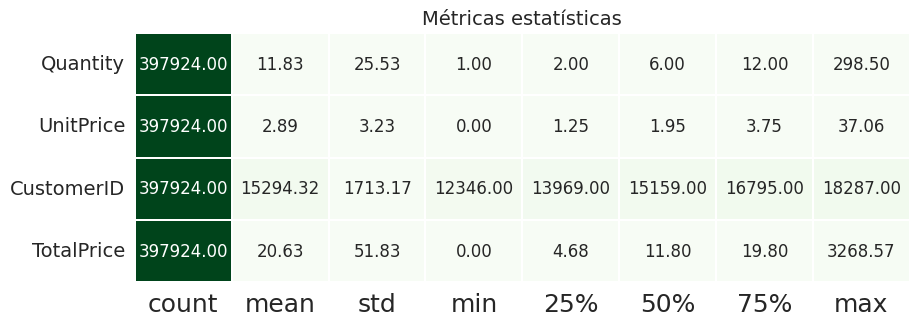

In [50]:
df = ecommerce_preprocess(df)

desc_stats(df.select_dtypes(include = [float, int]))

▶ Podemos observar que a quantiade de linhas caem, e a média de Quantity aumenta. Passando uma informação mais precisa

## Métricas RFM

▶ A Análise RFM (Recency, Frequency, Monetary) é uma técnica usada para segmentar clientes com base em três critérios:


*   Recency (Recência): Refere-se ao tempo desde a última interação ou compra do cliente. Quanto mais recente, mais valioso o cliente é considerado.
*   Frequency (Frequência): Mede a quantidade de vezes que o cliente comprou em um período determinado. Clientes que compram com mais frequência tendem a ser mais leais.
*  Monetary (Monetário): Avalia o valor total gasto pelo cliente durante um período. Clientes que gastam mais são mais valiosos.


▶ A análise RFM é útil para identificar clientes com alto potencial de vendas, segmentar os clientes em diferentes grupos e tomar decisões de marketing mais assertivas, como campanhas direcionadas.



In [35]:
print(df['InvoiceDate'].max())

9/9/2011 9:52


In [37]:
import pandas as pd
import datetime as dt

today_date = dt.datetime(2011, 12, 11)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (today_date - x.max()).days,
    'InvoiceNo': lambda x: x.nunique(),
    'TotalPrice': lambda x: x.sum()
})

rfm.columns = ['recency', 'frequency', 'monetary']

rfm = rfm[rfm['monetary'] > 0]

rfm = rfm.reset_index()

rfm.head()

,CustomerID,recency,frequency,monetary
0,12346.0,326,1,310.44
1,12347.0,3,7,4310.00
2,12348.0,76,4,1770.78
3,12349.0,19,1,1491.72
4,12350.0,311,1,331.46


▶ Podemos agrupar os dados por cliente para identificar a data da última compra, a quantidade de pedidos únicos e o total gasto em compras. Com essas informações, já é possível identificar os melhores clientes de forma clara e eficiente.

# RFM Scores

In [38]:
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()
    df_["recency_score"] = pd.qcut(df_["recency"], 5, labels=[5, 4, 3, 2, 1])
    df_["frequency_score"] = pd.qcut(
        df_["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]
    )
    df_["monetary_score"] = pd.qcut(df_["monetary"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFM_SCORE"] = df_["recency_score"].astype(str) + df_["frequency_score"].astype(
        str
    )

    return df_


rfm = get_rfm_scores(rfm)

# Segmentando os clientes

In [51]:
seg_map = {r'[1-2][1-2]': 'desistente',
           r'[1-2][3-4]': 'em_risco',
           r'[1-2]5': 'podemos perder',
           r'3[1-2]': 'diminuindo',
           r'33': 'atenção_necessária',
           r'[3-4][4-5]': 'clientes_fiéis',
           r'41': 'promissores',
           r'51': 'novos_clientes',
           r'[4-5][2-3]': 'fiéis_em_potencial',
           r'5[4-5]': 'campeões'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346.0,326,1,310.44,1,1,2,11,desistente
1,12347.0,3,7,4310.00,5,5,5,55,campeões
2,12348.0,76,4,1770.78,2,4,4,24,em_risco
3,12349.0,19,1,1491.72,4,1,4,41,promissores
4,12350.0,311,1,331.46,1,1,2,11,desistente


▶ Podemos criar um ranking para agrupar os clientes com base nas métricas RFM, o que nos permite segmentá-los de forma mais eficaz. Ao separar os clientes em grupos distintos, conseguimos visualizar claramente os diferentes públicos e tomar decisões estratégicas mais assertivas para cada segmento.

# Mapa de segmentação

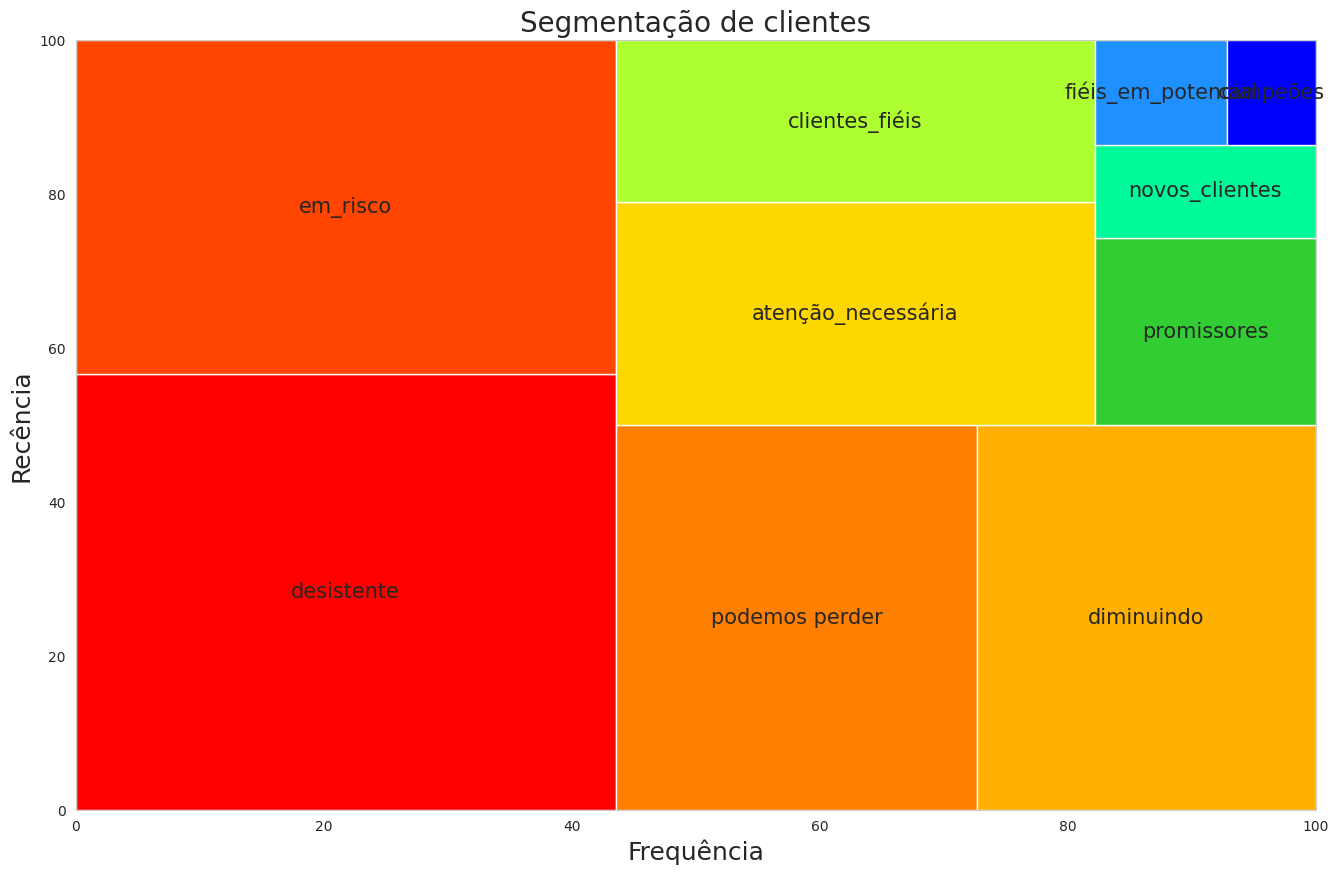

In [53]:
segments = rfm["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(
    sizes=segments,
    label=[label for label in seg_map.values()],
    color=[
        "#FF0000",
        "#FF4500",
        "#FF7F00",
        "#FFB000",
        "#FFD700",
        "#ADFF2F",
        "#32CD32",
        "#00FA9A",
        "#1E90FF",
        "#0000FF",
    ],
    pad=False,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 15},
)
plt.title("Segmentação de clientes", fontsize=20)
plt.xlabel("Frequência", fontsize=18)
plt.ylabel("Recência", fontsize=18)
plt.show()

▶ O mapa de segmentação oferece uma visualização clara da quantidade de clientes em cada categoria, permitindo uma compreensão rápida do perfil de cada grupo. Com essas informações, é possível tomar decisões mais assertivas sobre as ações a serem adotadas para cada segmento de clientes.